# RAMP starting kit on the Human Locomotion data set

#### Publication

Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9. [[doi]](https://doi.org/10.5201/ipol.2019.265) [[pdf]](http://deepcharles.github.io/files/ipol-walk-data-2019.pdf) [[online demo]](http://ipolcore.ipol.im/demo/clientApp/demo.html?id=265)

## Getting Started

### Prerequisites

- Python >=3.7
- numpy
- scipy
- pandas
- scikit-learn
- matplolib
- jupyter
- ramp-workflow

The following cell will install if necessary the missing dependencies.

In [1]:
import sys
!{sys.executable} -m pip install scikit-learn

# Install ramp-workflow from the master branch on GitHub.
!{sys.executable} -m pip install https://api.github.com/repos/paris-saclay-cds/ramp-workflow/zipball/master

     \ 4.4 MB 152 kB/s
  Created wheel for ramp-workflow: filename=ramp_workflow-0.4.0.dev0-py3-none-any.whl size=124908 sha256=2cda81997f8a0b15d6916faa618de4525aa5dae51866aa3932deecb57c1db830
  Stored in directory: /tmp/pip-ephem-wheel-cache-6h16t1r0/wheels/62/9d/79/0bf798131db514100fbb090d0f57c4427ed8ac079eee994227
Successfully built ramp-workflow
  Attempting uninstall: ramp-workflow
    Found existing installation: ramp-workflow 0.3.3
    Uninstalling ramp-workflow-0.3.3:
      Successfully uninstalled ramp-workflow-0.3.3


In [2]:
%load_ext autoreload
%autoreload 2

In order to download the download the data, execute the following command:

```
python download_data.py
```

## Introduction

**Context.**

The study of human gait is a central problem in medical research with far-reaching consequences in the public health domain.
This complex mechanism can be altered by a wide range of pathologies (such as Parkinson’s disease, arthritis, stroke,...), often resulting in a significant loss of autonomy and an increased risk of fall.
Understanding the influence of such medical disorders on a subject's gait would greatly facilitate early detection and prevention of those possibly harmful situations.
To address these issues, clinical and bio-mechanical researchers have worked to objectively quantify gait characteristics.


Among the gait features that have proved their relevance in a medical context, several are linked to the notion of step (step duration, variation in step length, etc.), which can be seen as the core atom of the locomotion process.
Many algorithms have therefore been developed to automatically (or semi-automatically) detect gait events (such as heel-strikes, heel-off, etc.) from accelerometer/gyrometer signals.

Most of the time, the algorithms used for step detection are dedicated to a specific population (healthy subjects, elderly subjects, Parkinson patients, etc.) and only a few publications deal with heterogeneous populations composed of several types of subjects.
Another limit to existing algorithms is that they often focus on locomotion in established regime (once the subject has initiated its gait) and do not deal with steps during U-turn, gait initiation or gait termination.
Yet, initiation and termination steps are particularly sensitive to pathological states.
For example, the first step of Parkinsonian patients has been described as slower and smaller that the first step of age-matched subjects.
U-turn steps are also interesting since 45% of daily living walking is made up of turning steps, and when compared to straight-line walking, turning has been emphasized as a high-risk fall situation.
This argues for reliable algorithms that could detect initiation, termination and turning steps in both healthy and pathological subjects.


**Step detection.**

The objective is to recognize the **start and end times of footsteps** contained in accelerometer and gyrometer signals recorded with Inertial Measurement Units (IMUs).



## Data

### Clinical protocol and data collection


#### Participants.

The data was collected between April 2014 and October 2015 by monitoring healthy (control) subjects and patients from several medical departments (see [publication](#Publication) for more information).
Participants are divided into three groups depending on their impairment:
- **Healthy** subjects had no known medical impairment.
- The **orthopedic group** is composed of 2 cohorts of distinct pathologies: lower limb osteoarthrosis and cruciate ligament injury.
- The **neurological group** is composed of 4 cohorts: hemispheric stroke, Parkinson's disease, toxic peripheral neuropathy and radiation induced leukoencephalopathy.

#### Protocol and equipment

All subjects underwent the same protocol described below. First, two IMUs (Inertial Measurement Unit) that recorded accelerations and angular velocities were attached to the body.
All signals have been acquired at 100 Hz with two brands of IMUs: XSens&trade; and Technoconcept&reg;.
Both were attached to the dorsal face of each foot.
After sensor fixation, participants were asked to perform the following sequence of activities:
- stand for 6 s,
- walk 10 m at preferred walking speed on a level surface to a previously shown turn point,
- turn around (without previous specification of a turning side),
- walk back to the starting point,
- stand for 2 s.

Subjects walked at their comfortable speed with their shoes and without walking aid.
This protocol is schematically illustrated in the following figure.
<img src="images/protocol-schema.png" alt="drawing" width="500"/>

Each IMU records its acceleration and angular velocity in the $(X, Y, Z, V)$ set of axes defined in the following figure.
The $V$ axis is aligned with gravity, while the $X$, $Y$ and $Z$ axes are attached to the sensor.
<img src="images/sensor-position.png" alt="drawing" width="500"/>
<img src="images/sensor-photo.png" alt="drawing" width="500"/>

## Data

In [3]:
# loading the data
from problem import get_train_data, get_test_data

data_train, labels_train = get_train_data()
data_test, labels_test = get_test_data()
# print some information
msg = f"There are {len(data_train)} elements in the training set, and {len(data_test)} in the testing set."
print(msg)

There are 1304 elements in the training set, and 328 in the testing set.


Each element of either `data_train` or `data_test` consists of a signal and a set of metadata and each label consists of a list of footsteps (start and end indexes).

In [4]:
# illustrative trial
index = 60
trial, step_list = data_train[index], labels_train[index]

### Signal

Each IMU that the participants wore provided $\mathbb{R}^{8}$-valued signals, sampled at 100 Hz.
In this setting, each dimension is defined by the signal type (`A` for acceleration, `R` for angular velocity) and the axis (`X`, `Y`, `Z` or `V`).
For instance, `RX` denotes the angular velocity around the `X`-axis.
Accelerations are given in $m/s^2$ and angular velocities, in $deg/s$.
The signal is available in the `.signal` attribute as a `Pandas` dataframe.

Each row in the signal dataframe represents the signal obtained from the left or right foot of one participant. Thus for each 'trail' there would be two signals, one from each foot.

,AV,AX,AY,AZ,RV,RX,RY,RZ
0,0.007698,0.003941,0.000622,0.006683,0.797232,1.267669,-0.994483,0.393393
1,-0.001410,0.004106,-0.000487,-0.004047,1.380072,1.497196,-1.005426,0.950766
2,-0.000029,0.003366,-0.005620,-0.000811,0.925991,1.223952,-1.562742,0.699410
3,0.000070,0.003529,0.000703,-0.002191,1.124624,1.049143,-0.349733,0.775899
4,-0.004615,-0.000525,-0.003162,-0.004442,0.786267,0.655693,0.448053,0.437109


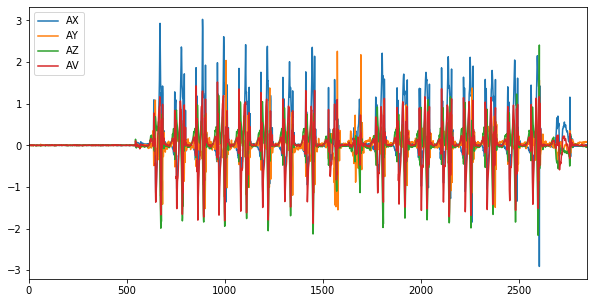

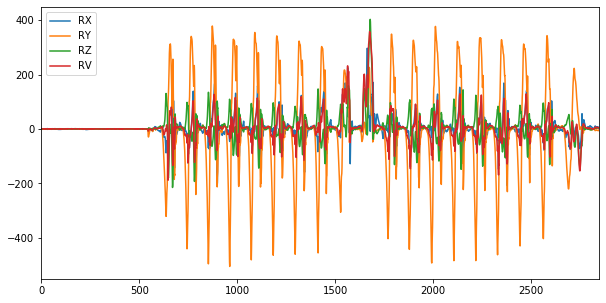

In [5]:
# The signal is available in the `signal` attribute.
trial.signal[["AX", "AY", "AZ", "AV"]].plot(figsize=(10, 5))  # select the accelerations
trial.signal[["RX", "RY", "RZ", "RV"]].plot(figsize=(10, 5))  # select the angular velocities

trial.signal.head()

The "flat part" at the beginning of each dimension is the result of the participants standing still for a few
seconds before walking (see [Protocol](#Protocol-and-equipment)).
The same behaviour can be seen at the end of each dimension (often but not always), though for a quite smaller duration.

###  Metadata
A number of metadata (either numerical or categorical) are provided for each signal (sample), detailing the participant being monitored and the sensor position:

- `code`: unique identifier for the trial;
- `age` (in years);
- `gender`: male ("M") or female ("F");
- `height` (in meters);
- `weight` (in kilograms);
- `bmi` (in kg/m2): body mass index;
- `laterality`: subject's "footedness" or "foot to kick a ball" ("Left", "Right" or "Ambidextrous").
- `sensor`: brand of the IMU used for the recording (“XSens” or “TCon”);
- `pathology_group`: this variable takes value in {“Healthy”, “Orthopedic”, “Neurological”};
- `is_control`: whether the subject is a control subject ("Yes" or "No");
- `foot`: foot on which the sensor was attached ("Left" or "Right").

These are accessible using the notation `trial.<metadata>`.

In [6]:
msg = f"""Metadata:
age\t\t{trial.age},
gender\t\t{trial.gender},
height\t\t{trial.height},
weight\t\t{trial.weight},
bmi\t\t{trial.bmi},
laterality\t{trial.laterality},
sensor\t\t{trial.sensor},
pathology_group\t{trial.pathology_group},
foot\t\t{trial.foot}"""
print(msg)

Metadata:
age		83,
gender		F,
height		1.62,
weight		60,
bmi		22.9,
laterality	Right,
sensor		XSens,
pathology_group	Orthopedic,
foot		Left


### Step annotation (the "label" to predict)
Footsteps were manually annotated by specialists using a software that displayed the signals from the relevant sensor (left or right foot) and allowed the specialist to indicate the starts and ends of each step.

A footstep is defined as the period during which the foot is moving.
Footsteps are separated by periods when the foot is still and flat on the floor.
Therefore, in our setting, a footstep starts with a heel-off and ends with the following toe-strike of the same foot.


Footsteps (the "label" to predict from the signal) are contained in a list whose elements are list of two integers, the start and end indexes. For instance:

In [7]:
print(step_list)

[[612, 691], [727, 802], [833, 908], [941, 1016], [1050, 1127], [1160, 1240], [1276, 1355], [1393, 1464], [1501, 1587], [1633, 1707], [1741, 1819], [1861, 1942], [1977, 2053], [2087, 2166], [2202, 2277], [2315, 2389], [2426, 2508], [2540, 2622], [2674, 2772]]


Visualization of footsteps and signals:

For the trial '3-475', 19 footsteps were annotated on the left foot:
[[612, 691], [727, 802], [833, 908], [941, 1016], [1050, 1127], [1160, 1240], [1276, 1355], [1393, 1464], [1501, 1587], [1633, 1707], [1741, 1819], [1861, 1942], [1977, 2053], [2087, 2166], [2202, 2277], [2315, 2389], [2426, 2508], [2540, 2622], [2674, 2772]]


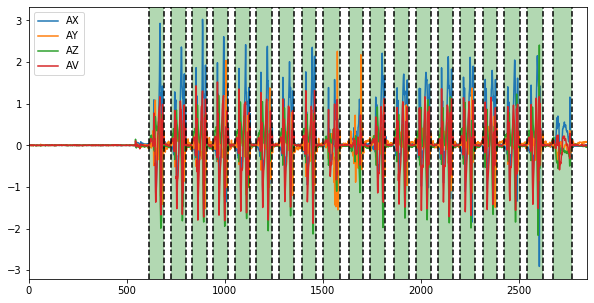

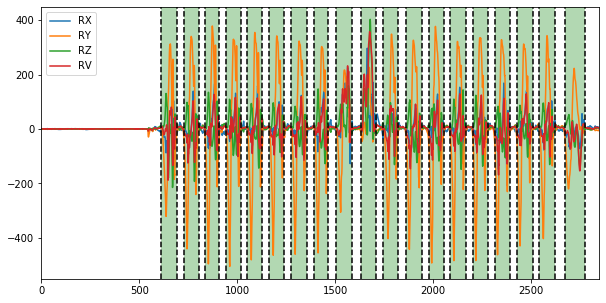

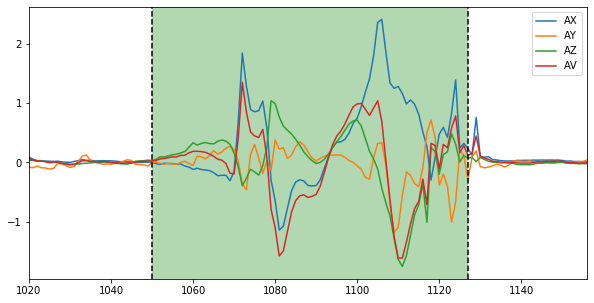

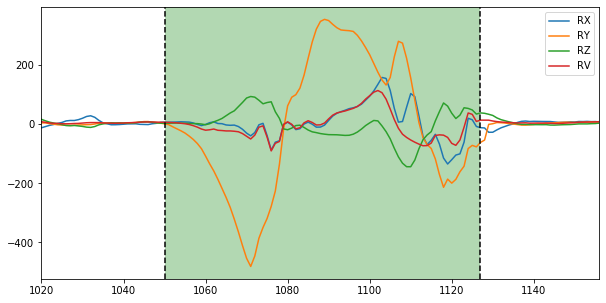

In [8]:
msg = f"For the trial '{trial.code}', {len(step_list)} footsteps were annotated on the {trial.foot.lower()} foot:"
print(msg)
print(step_list)

# Color the footsteps
ax = trial.signal[["AX", "AY", "AZ", "AV"]].plot(figsize=(10, 5))
line_args = {"linestyle": "--", "color": "k"}
for (start, end) in step_list:
    ax.axvline(start, **line_args)
    ax.axvline(end, **line_args)
    ax.axvspan(start, end, facecolor='g', alpha=0.3)

ax = trial.signal[["RX", "RY", "RZ", "RV"]].plot(figsize=(10, 5))
for (start, end) in step_list:
    ax.axvline(start, **line_args)
    ax.axvline(end, **line_args)
    ax.axvspan(start, end, facecolor='g', alpha=0.3)

# Close-up on a footstep
start, end = step_list[4]

ax = trial.signal[["AX", "AY", "AZ", "AV"]][start-30:end+30].plot(figsize=(10, 5))
ax.axvline(start, **line_args)
ax.axvline(end, **line_args)
ax.axvspan(start, end, facecolor='g', alpha=0.3)

ax = trial.signal[["RX", "RY", "RZ", "RV"]][start-30:end+30].plot(figsize=(10, 5))
ax.axvline(start, **line_args)
ax.axvline(end, **line_args)
ax.axvspan(start, end, facecolor='g', alpha=0.3)


**On the first two plots.**
The repeated patterns (colored in light green) correspond to periods when the foot is moving.
During the non-annotated periods, the foot is flat and not moving and the signals are constant.
Generally, steps at the beginning and end of the trial, as well as during the u-turn (in the middle of the signal approximatively, see [Protocol](#Protocol-and-equipment)) are a bit different from the other ones.

**On the last two plots.** A close-up on a single footstep.

### General comments

- Some of the described variables can take the value "NC" which stands for "Not Communicated". This label replaces missing data and depending on the variable may affect up to 2% of the database.

- In the whole data set, each `code` value appears exactly twice, because a single trial yields a signal for the right foot and another for the left foot.

- There are uncertainties in the definition of the starts and ends of the steps. Indeed, we can see on previous figures, that the start and ends could be slightly moved. However, our choice of metric is relatively immune to small variations in the start and end of footsteps.

- There are a lot of variability in the step patterns depending on the pathology, the age, the weight, etc. We invite the participants to skim through the different trials to see how footsteps vary. Generally, long signals (over 40 seconds) display pathological behaviours.

### Simple data exploration

In [9]:
from collections import Counter

import numpy as np


def get_avg_min_max(a_list) -> str:
    """[a_1, a_2,...] -> 'avg (min: minimum, max: maximum)'"""
    return f'{np.mean(a_list):.1f} (min: {np.min(a_list):.1f}, max: {np.max(a_list):.1f})'

print("On average, in the training set:")

# Trial duration
sampling_freq = 100 # Hz
trial_duration_list = [trial.signal.shape[0]/sampling_freq for trial in data_train]
print(f"- a trial lasts {get_avg_min_max(trial_duration_list)} seconds;")


# Number of steps per trial per foot
n_steps_list = [len(step_list) for step_list in labels_train]
print(f"- there are {get_avg_min_max(n_steps_list)} steps per trial per foot;")

# Footstep duration
step_duration_list = list()
for step_list in labels_train:
    step_duration_list.extend(np.diff(step_list).flatten()/sampling_freq)  # list of footstep durations
print(f"- a footstep lasts {get_avg_min_max(step_duration_list)} second;")

# Pathology distribution
pathology_counter = Counter(trial.pathology_group for trial in data_train)
print(f"- group distribution: {pathology_counter['Healthy']} 'Healthy', {pathology_counter['Neurological']} 'Neurological', {pathology_counter['Orthopedic']} 'Orthopedic';")

On average, in the training set:
- a trial lasts 30.6 (min: 11.7, max: 186.4) seconds;
- there are 20.1 (min: 7.0, max: 79.0) steps per trial per foot;
- a footstep lasts 0.8 (min: 0.2, max: 1.8) second;
- group distribution: 310 'Healthy', 684 'Neurological', 310 'Orthopedic';


## Workflow

### Performance metric

Step detection methods will be evaluated with the **F-score**, based on the following precision/recall definition. 

- Precision (or positive predictive value). A detected step is counted as correct if the mean of its start and end times lies inside an annotated step. An annotated step can only be detected one time. If several detected steps correspond to the same annotated step, all but one are considered as false. The precision is the number of correctly detected steps divided by the total number of detected steps.
- Recall (or sensitivity). An annotated step is counted as detected if the mean of its start and end times lies inside a detected step. A detected step can only be used to detect one annotated step. If several annotated steps are detected with the same detected step, all but one are considered undetected. The recall is the number of detected annotated steps divided by the total number of annotated steps.

The F-score is simply the geometric mean of the precision and recall: $$2\times\frac{\text{precision}\times\text{recall}}{\text{precision}+\text{recall}}.$$

All methods are evaluated with a cross-validation.

### Simple step detection: template matching

To illustrate, a simple step detection method is described now.
It is based on template matching:
- A random step is chosen (the template).
- For any new signal, the sliding correlation is computed between this template. High correlation indicates a similar pattern.
- A peak detection method is applied on the correlation signal.

To reduce the computation, only the accelerations are used (angular velocities are discarded).

In [10]:
from random import choice, seed

RANDOM_STATE = 7
seed(RANDOM_STATE)

Metadata:
age		25,
gender		M,
height		1.78,
weight		77,
bmi		24.3,
laterality	Right,
sensor		XSens,
pathology_group	Healthy,
foot		Right


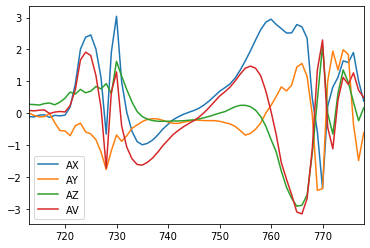

In [11]:
# choose a trial at random
trial, step_list = choice([*zip(data_train, labels_train)])

msg = f"""Metadata:
age\t\t{trial.age},
gender\t\t{trial.gender},
height\t\t{trial.height},
weight\t\t{trial.weight},
bmi\t\t{trial.bmi},
laterality\t{trial.laterality},
sensor\t\t{trial.sensor},
pathology_group\t{trial.pathology_group},
foot\t\t{trial.foot}"""
print(msg)

# choose a step template at random
start, end = choice(step_list)

# only keep the acceleration (not the angular velocity)
# to reduce computations
template = trial.signal[start:end][["AX", "AY", "AZ", "AV"]]
template.plot()

Sliding correlation between signal.AX and template.AX, signal.AY and template.AY, etc. Then max pooling across the four dimensions.

/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """


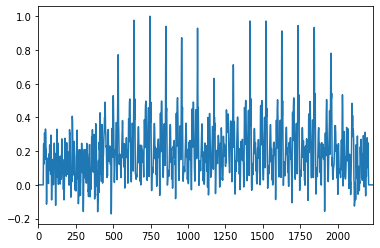

In [12]:
from scipy.signal import argrelmax

score = (trial.signal[["AX", "AY", "AZ", "AV"]]  # select the accelerations
         .rolling(template.shape[0], center=True)  # sliding window of the same shape of the template
         .apply(lambda x: np.diag(np.corrcoef(x, template, rowvar=False), k=4))  # correlation
         .max(axis=1)  # max pooling
         .fillna(0))  # to remove NaNs at the edges
score.plot()

The maximums of correlation corresponds to detected steps with our template.
All that remains is to find them automatically.
A simple peak detection heuristic consists in keeping all points that are greater than all samples in a small neighbourhood.
In addition, all values below a certain threshold are set to 0, to prevent from detecting steps with low correlations. 

Number of detected steps: 15, number of actual steps: 14.
[[483, 583], [589, 689], [696, 796], [802, 902], [908, 1008], [1014, 1114], [1124, 1224], [1253, 1353], [1365, 1465], [1472, 1572], [1577, 1677], [1686, 1786], [1794, 1894], [1906, 2006], [1983, 2083]]


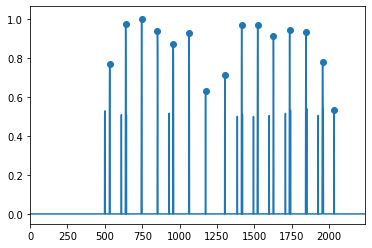

In [13]:
threshold = 0.5
order = 50  # size of the neighbourhood

score[score<threshold] = 0.0  # set to 0 all values below a threshold
indexes, = argrelmax(score.to_numpy(), order=order)  # to find local maxima

# plot the peaks
ax = score.plot()
ax.scatter(indexes, score[indexes])

# make the prediction
# detected steps are centered on the detected peaks and have size 2*order (here 100 samples, not very dynamic).
predicted_steps = [[t-order, t+order] for t in indexes]
print(f"Number of detected steps: {len(predicted_steps)}, number of actual steps: {len(step_list)}.")
print(predicted_steps)

We can compute the F-score on our training example, and then on a testing example.

In [14]:
from problem import FScoreStepDetection


fscore = FScoreStepDetection()([step_list], [predicted_steps])
print(f"(code: {trial.code})")
print(f"F-score: {fscore:.2f}", end=' ')
if fscore>0.9:
    print("(not bad)")

(code: 3-25)
F-score: 0.97 (not bad)


In [15]:
# testing example
trial, step_list = choice([*zip(data_train, labels_train)])
print(f"(code: {trial.code})")
score = (trial.signal[["AX", "AY", "AZ", "AV"]]  # select the accelerations
         .rolling(template.shape[0], center=True)  # sliding window of the same shape as the template
         .apply(lambda x: np.diag(np.corrcoef(x, template, rowvar=False), k=4))  # correlations
         .max(axis=1)  # max pooling
         .fillna(0))  # to remove NaNs at the edges
score[score<threshold] = 0.0  # set to 0 all values below a threshold
indexes, = argrelmax(score.to_numpy(), order=order)  # to find local maxima
predicted_steps = [[t-order, t+order] for t in indexes]

fscore = FScoreStepDetection()([step_list], [predicted_steps])
print(f"F-score: {fscore:.2f}", end= ' ')
if fscore<0.9:
    print("(bad generalization)")

(code: 3-179)


/home/lucy/miniconda3/envs/FAN/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  


F-score: 0.86 (bad generalization)


### Submitting to RAMP

The example solution presented above is implemented in the sample submission `submissions/starting_kit_1/estimator.py`. The code in this file defines a function called `get_estimator()` that returns a scikit-learn pipeline that performs the same steps as described above:

In [16]:
from random import choice, seed

import numpy as np
from scipy.signal import argrelmax
from scipy.stats.stats import pearsonr
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline

RANDOM_STATE = 7
seed(RANDOM_STATE)


class Detector(BaseEstimator):
    def __init__(self, threshold=0.5, order=40):
        self.threshold = threshold
        self.order = order
        self.step_template = None

    def fit(self, X, y):
        assert len(X) == len(
            y), f"Wrong dimensions (len(X): {len(X)}, len(y): {len(y)})."

        # take a step at random
        trial, step_list = choice([*zip(X, y)])
        start, end = choice(step_list)
        self.step_template = trial.signal[["AX", "AY", "AZ", "AV"]][start:end]
        return self

    def predict(self, X):
        y_pred = list()
        for trial in X:
            score = (trial.signal[["AX", "AY", "AZ", "AV"]]  # select the accelerations
                     # sliding window, same shape as the template
                     .rolling(self.step_template.shape[0], center=True)
                     # correlations
                     .apply(lambda x: np.diag(np.corrcoef(x, self.step_template, rowvar=False), k=4))
                     # max pooling
                     .max(axis=1)
                     # to remove NaNs at the edges
                     .fillna(0))
            # set to 0 all values below a threshold
            score[score < self.threshold] = 0.0
            # to find local maxima
            indexes, = argrelmax(score.to_numpy(), order=self.order)
            predicted_steps = [[t - self.order, t + self.order] for t in indexes]
            y_pred += [predicted_steps]
        return np.array(y_pred, dtype=list)


def get_estimator():
    # step detection
    detector = Detector()

    # make pipeline
    pipeline = Pipeline(steps=[('detector', detector)])

    return pipeline

The `get_estimator()` should return an object (your algorithm) with a `.fit()` and a `.predict()` method, which will be evaluated on a cross-validation.
Other files and functions will only be read/executed if they are read/executed by `get_estimator()`.

Another (even simpler) example can be found in `submissions/starting_kit/`.

In these examples, no real learning or hyperparameter search are performed, but any method will clearly benefit from such procedures. Once you have a submission ready, save your submission code in file named `estimator.py`, which should be stored in a folder (e.g., `my_submission`) within `submissions` (e.g., within `submissions/my_submission/estimator.py`). You can not test your code locally test with:

```
ramp-test --submission <submission folder name>
```

where `<submission folder name>` should be the name of the submission folder (e.g., `my_submission`).

**Check list.**
- Make sure you have installed ramp-workflow locally (see above)
- Make sure that the python file `estimator.py` is in `submissions/<submission folder>`, and the train and test data are in data
- If you haven't yet, download the data by executing

```
python download_data.py
```

Finally, make sure the local processing goes through by running the
```
ramp-test --submission <submission folder>
```
If you want to quickly test the that there are no obvious code errors, use the `--quick-test` flag to only use data from the first 30 instances.

```
ramp-test --submission <submission folder> --quick-test
```

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.